In [5]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=False)

x, y = torch.tensor(iris["data"]).to(torch.float), torch.tensor(iris["target"])
# print(x.shape)

About Dataset

- Feature space

'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'

- Label space

'setosa', 'versicolor', 'virginica'

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# from sklearn.model_selection import train_test_split

In [33]:
res = 100
search_area = 0.01

How to visualize the high dimensional space(n(dji)+1) into 3 dimensional space?

-> Use only random 2 directional vectors for bridging this issue! (intuitive visualization methods)

There's some problem! The scale invariant property of relu activation function indicates that we should normalize random vectors to keep under-control! The popular way to alleviate this issue by simple techniques [Filter-wise normalization technique](https://proceedings.neurips.cc/paper_files/paper/2018/file/a41b3bb3e6b050b6c9067c67f663b915-Paper.pdf).

-> Dij <- Dij/|Dij| * thetaij

Dji = random vector

In [56]:
shape = torch.zeros(10, 20).shape
[10, 10, *list(shape)]

[10, 10, 10, 20]

In [74]:
def get_loss_landscape(net, data_x, data_y, loss_func):
    interested_p = {}
    for n, p in net.named_parameters():
        if "weight" in n:
            # interested_p.append(n)
            # out = [(curr:=curr*v) for v in p.shape][-1]
            interested_p[n] = p
    x, y = torch.linspace(-search_area, search_area, res), torch.linspace(-search_area, search_area, res)
    grid = torch.meshgrid(x, y) # [2, (20, 20)]

    a = grid[0]
    b = grid[1]
    d_mesh_by_name = {} # name: [v1 or v2, (res, res, *weight shape)]
    directions_by_name = {} # name: flattened v1 or v2
    for name, p in interested_p.items():
        directions = []
        for i in range(2):
            random_d = torch.randn_like(p)
            vi = random_d / random_d.norm(-1) * p
            directions.append(vi)
        directions_by_name[name] = [vi.view(-1) for vi in directions]
        shape = list(p.shape) # torch.Size -> list
        v1_mesh = directions[0].reshape(-1).unsqueeze(0).unsqueeze(0) * a.unsqueeze(2)
        v2_mesh = directions[1].reshape(-1).unsqueeze(0).unsqueeze(0) * b.unsqueeze(2)
        d_mesh_by_name[name] = (v1_mesh.view(res, res, *shape), v2_mesh.view(res, res, *shape)) # *list[a, b] -> a, b

    losses = torch.zeros(res, res)
    for i in range(res):
        for j in range(res):
            # Shift cloned network!
            cloned_network = deepcopy(net)
            with torch.no_grad():
                for n, p in cloned_network.named_parameters():
                    if n not in d_mesh_by_name.keys():
                        continue
                    d1 = d_mesh_by_name[n][0][i, j]
                    d2 = d_mesh_by_name[n][1][i, j]
                    p += d1 + d2
            yhat = cloned_network(data_x)
            loss = loss_func(data_y, yhat)
            losses[i, j] = loss.item()

    # Getting direction of grad to visualize learning trajectory
    grad_dir = [] # mean(dot product of grad&dir1 dir2)
    yhat = net(data_x)
    loss = loss_func(data_y, yhat)
    loss.backward()
    dot_of_v1_and_grad = []
    dot_of_v2_and_grad = []
    with torch.no_grad():
        grad_dir_v1_buf = []
        grad_dir_v2_buf = []
        for n, p in net.named_parameters():
            if n not in d_mesh_by_name.keys():
                continue
            grad = p.grad.view(-1) # flatten it
            v1 = directions_by_name[n][0]
            v2 = directions_by_name[n][1]
            dot_grad_and_v1 = (grad.T @ v1).item()
            dot_grad_and_v2 = (grad.T @ v2).item()
            grad_dir_v1_buf.append(dot_grad_and_v1)
            grad_dir_v2_buf.append(dot_grad_and_v2)
        grad_dir = [sum(grad_dir_v1_buf), sum(grad_dir_v2_buf)]
    
    return losses.detach().numpy(), grad_dir

In [75]:
class Net(nn.Module):
    def __init__(self, act):
        super().__init__()
        self.linear1 = nn.Linear(4, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(10, 3)
        # self.relu = nn.ReLU()
        self.act = act
    def forward(self, x):
        # res_x = self.linear4(x)        
        x = self.act(self.linear1(x))
        x = self.act(self.linear2(x))
        # x = self.linear3(x) + res_x
        x = self.linear3(x)
        return x

def loss_func(y, yhat):
    return torch.nn.functional.cross_entropy(yhat, y, reduction="mean")

In [78]:
tanh_net = Net(nn.Tanh())
relu_net = Net(nn.ReLU())
leaky_net = Net(nn.LeakyReLU())

tanh_optimizer = torch.optim.SGD(tanh_net.parameters(), 0.05)
relu_optimizer = torch.optim.SGD(relu_net.parameters(), 0.05)
leaky_optimizer = torch.optim.SGD(leaky_net.parameters(), 0.05)

initial_relu_landscape, relu_grad_dir = get_loss_landscape(relu_net, x, y, loss_func)
initial_leaky_landscape, leaky_grad_dir = get_loss_landscape(leaky_net, x, y, loss_func)
initial_tanh_landscape, tanh_grad_dir = get_loss_landscape(tanh_net, x, y, loss_func)

In [83]:
relu_grad_dir, leaky_grad_dir, tanh_grad_dir

([0.3666677474975586, -9.07964301109314],
 [-55.69294834136963, 67.21684169769287],
 [17.21648859977722, 5.445276975631714])

In [45]:
import math
-math.log(1/3)
# loss 40 -> p=1/exp(40)

1.0986122886681098

In [38]:
loss_func(y, relu_net(x))

tensor(1.1040, grad_fn=<NllLossBackward0>)

In [37]:
initial_relu_landscape

array([[ 4.3831053,  4.179023 ,  3.9876773, ..., 45.47809  , 46.70821  ,
        47.951077 ],
       [ 4.3617344,  4.15685  ,  3.963678 , ..., 44.373737 , 45.573658 ,
        46.785896 ],
       [ 4.340902 ,  4.1357408,  3.941434 , ..., 43.273743 , 44.443474 ,
        45.625153 ],
       ...,
       [12.337509 , 11.953451 , 11.577305 , ...,  5.8313413,  6.2648215,
         6.7129583],
       [12.700747 , 12.309595 , 11.926646 , ...,  5.617247 ,  6.0514755,
         6.500756 ],
       [13.073473 , 12.675443 , 12.285665 , ...,  5.390759 ,  5.8251014,
         6.275098 ]], dtype=float32)

In [77]:
grad_dir

[-130.34707880020142, 34.00090050697327]

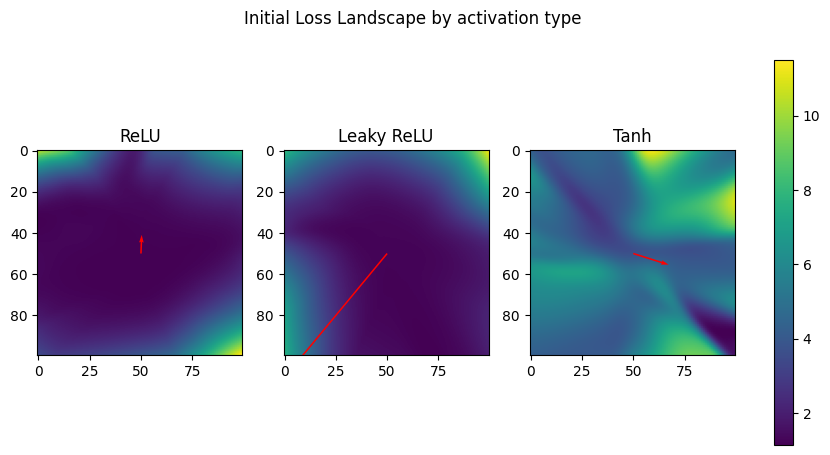

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

im0 = ax[0].imshow(initial_relu_landscape, cmap="viridis")
im1 = ax[1].imshow(initial_leaky_landscape, cmap="viridis")
im2 = ax[2].imshow(initial_tanh_landscape, cmap="viridis")

ax[0].quiver(int(res/2), int(res/2), relu_grad_dir[0], relu_grad_dir[1], color='r', scale=1, scale_units='xy', angles='xy')
ax[1].quiver(int(res/2), int(res/2), leaky_grad_dir[0], leaky_grad_dir[1], color='r', scale=1, scale_units='xy', angles='xy')
ax[2].quiver(int(res/2), int(res/2), tanh_grad_dir[0], tanh_grad_dir[1], color='r', scale=1, scale_units='xy', angles='xy')

cbar = fig.colorbar(im0, ax=ax, orientation="vertical", fraction=0.05, pad=0.05)

fig.suptitle("Initial Loss Landscape by activation type")
ax[0].set_title("ReLU")
ax[1].set_title("Leaky ReLU")
ax[2].set_title("Tanh")

plt.savefig("docs/loss_landscape.jpg")

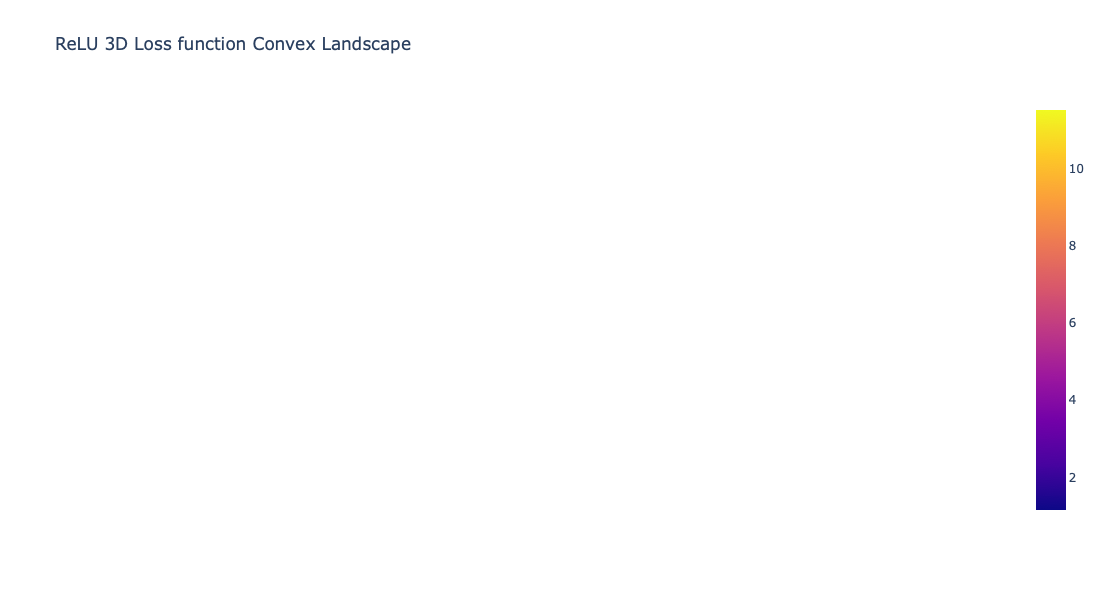

In [97]:
import plotly.graph_objects as go

X, Y = torch.meshgrid(torch.linspace(-search_area, search_area, res), torch.linspace(-search_area, search_area, res))

# Create a plotly surface plot
fig = go.Figure(data=[go.Surface(z=initial_relu_landscape, x=X, y=Y)], layout=go.Layout(width=600, height=600))

fig.update_layout(
    title="ReLU 3D Loss function Convex Landscape",
    scene=dict(
        xaxis_title="v1",
        yaxis_title="v2",
        zaxis_title="Loss"
    )
)

center_x = 0
center_y = 0
center_z = initial_relu_landscape[res//2, res//2]
arrow_u = relu_grad_dir[0]
arrow_v = relu_grad_dir[1]
arrow_w = 0  # Adjust if needed

# Add a cone (arrow) at the center of the surface
fig.add_trace(go.Cone(
    x=[center_x],
    y=[center_y],
    z=[center_z],
    u=[arrow_u],
    v=[arrow_v],
    w=[arrow_w],
    sizemode="absolute",
    sizeref=0.005,          # Adjust sizeref for arrow length scaling
    anchor="tail",      # Arrow starts at (center_x, center_y, center_z)
    showscale=False,    # Hide the color scale for the cone
    colorscale=[[0, "red"], [1, "red"]]
))

fig.show()

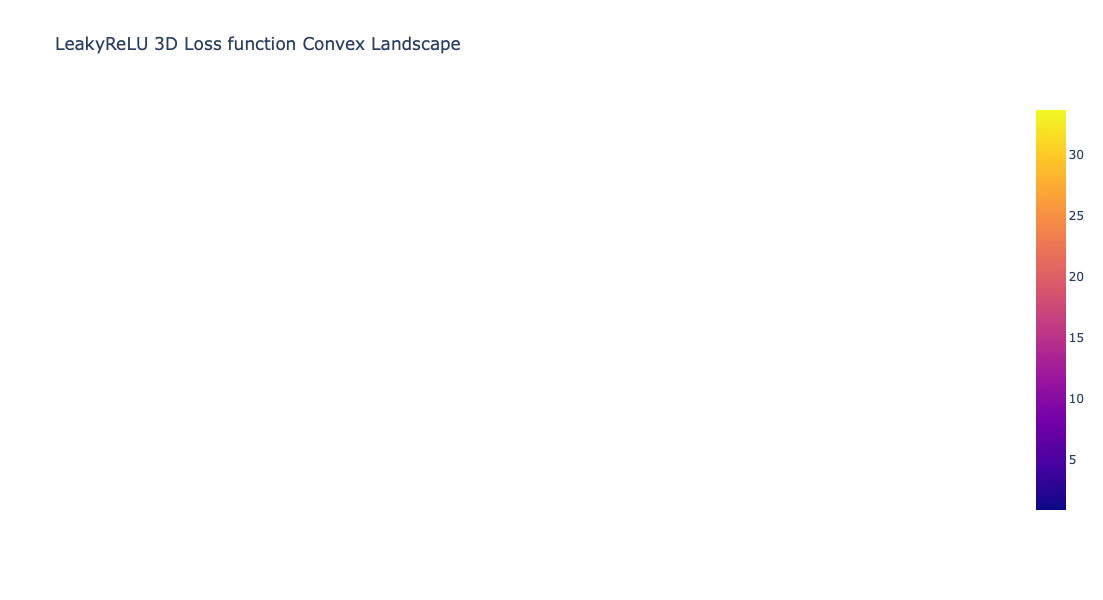

In [100]:
import plotly.graph_objects as go

X, Y = torch.meshgrid(torch.linspace(-search_area, search_area, res), torch.linspace(-search_area, search_area, res))

# Create a plotly surface plot
fig = go.Figure(data=[go.Surface(z=initial_leaky_landscape, x=X, y=Y)], layout=go.Layout(width=600, height=600))

fig.update_layout(
    title="LeakyReLU 3D Loss function Convex Landscape",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Loss"
    )
)

center_x = 0
center_y = 0
center_z = initial_leaky_landscape[res//2, res//2]
arrow_u = leaky_grad_dir[0]
arrow_v = leaky_grad_dir[1]
arrow_w = 0  # Adjust if needed

# Add a cone (arrow) at the center of the surface
fig.add_trace(go.Cone(
    x=[center_x],
    y=[center_y],
    z=[center_z],
    u=[arrow_u],
    v=[arrow_v],
    w=[arrow_w],
    sizemode="absolute",
    sizeref=0.005,          # Adjust sizeref for arrow length scaling
    anchor="tail",      # Arrow starts at (center_x, center_y, center_z)
    showscale=False,    # Hide the color scale for the cone
    colorscale=[[0, "red"], [1, "red"]]
))

fig.show()

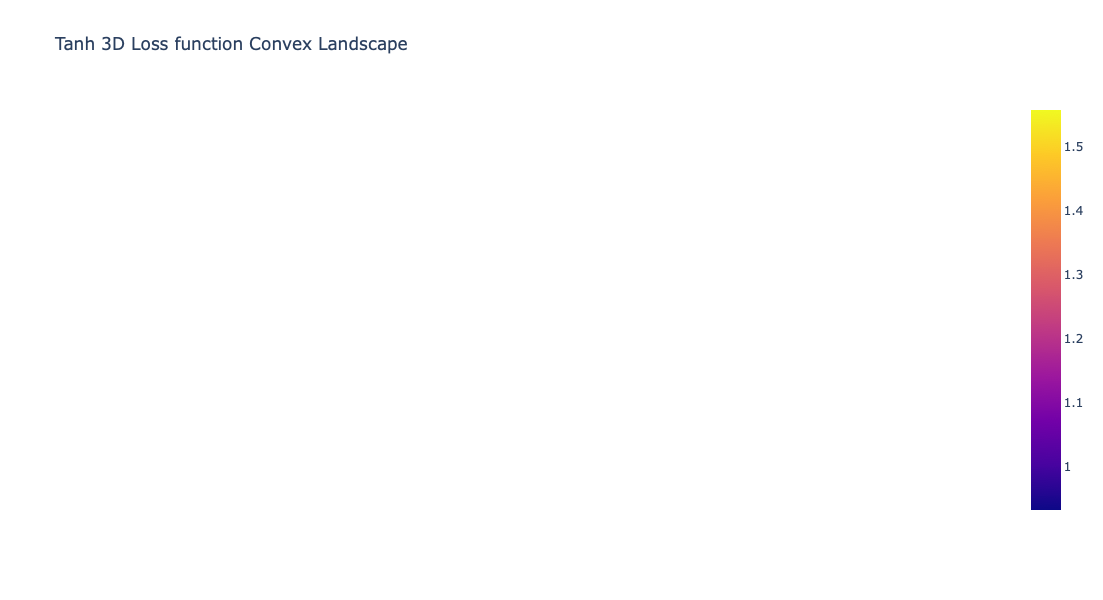

In [98]:
import plotly.graph_objects as go

X, Y = torch.meshgrid(torch.linspace(-search_area, search_area, res), torch.linspace(-search_area, search_area, res))

# Create a plotly surface plot
fig = go.Figure(data=[go.Surface(z=initial_tanh_landscape, x=X, y=Y)], layout=go.Layout(width=600, height=600))

fig.update_layout(
    title="Tanh 3D Loss function Convex Landscape",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Loss"
    )
)

center_x = 0
center_y = 0
center_z = initial_tanh_landscape[res//2, res//2]
arrow_u = tanh_grad_dir[0]
arrow_v = tanh_grad_dir[1]
arrow_w = 0  # Adjust if needed

# Add a cone (arrow) at the center of the surface
fig.add_trace(go.Cone(
    x=[center_x],
    y=[center_y],
    z=[center_z],
    u=[arrow_u],
    v=[arrow_v],
    w=[arrow_w],
    sizemode="absolute",
    sizeref=0.005,          # Adjust sizeref for arrow length scaling
    anchor="tail",      # Arrow starts at (center_x, center_y, center_z)
    showscale=False,    # Hide the color scale for the cone
    colorscale=[[0, "red"], [1, "red"]]
))

fig.show()